#### Importing the libraries

In [222]:
import pandas as pd
import numpy as np
import re
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras import optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#### loading and displaying the datasets

In [223]:

train_data = pd.read_csv('/content/SQLIV3_cleaned2.csv')
test_data = pd.read_csv('/content/sqliv2_utf8.csv')
print(train_data)

                                                Sentence  Label
0                      " or pg_sleep  (  __TIME__  )  --      1
1      create user name identified by pass123 tempora...      1
2       AND 1  =  utl_inaddr.get_host_address   (    ...      1
3       select * from users where id  =  '1' or @ @1 ...      1
4       select * from users where id  =  1 or 1#"  ( ...      1
...                                                  ...    ...
30609              DELETE FROM door WHERE grow = 'small'      0
30610                               DELETE FROM tomorrow      0
30611                       SELECT wide ( s )  FROM west      0
30612       SELECT * FROM  ( SELECT slide FROM breath )       0
30613                           SELECT TOP 3 * FROM race      0

[30614 rows x 2 columns]


In [224]:
train_data.duplicated().sum()

np.int64(12)

#### Remove duplicates from train and test sets.


In [225]:

train_data.drop_duplicates(subset='Sentence', keep='first', inplace=True)
test_data.drop_duplicates(subset='Sentence', keep='first', inplace=True)


In [226]:
train_data.duplicated().sum()

np.int64(0)

#### 'Label' Data Distribution


<ipython-input-227-4b886529f260>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=train_data, ax=ax[1], palette=colors)
<ipython-input-227-4b886529f260>:10: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.countplot(x='Label', data=train_data, ax=ax[1], palette=colors)


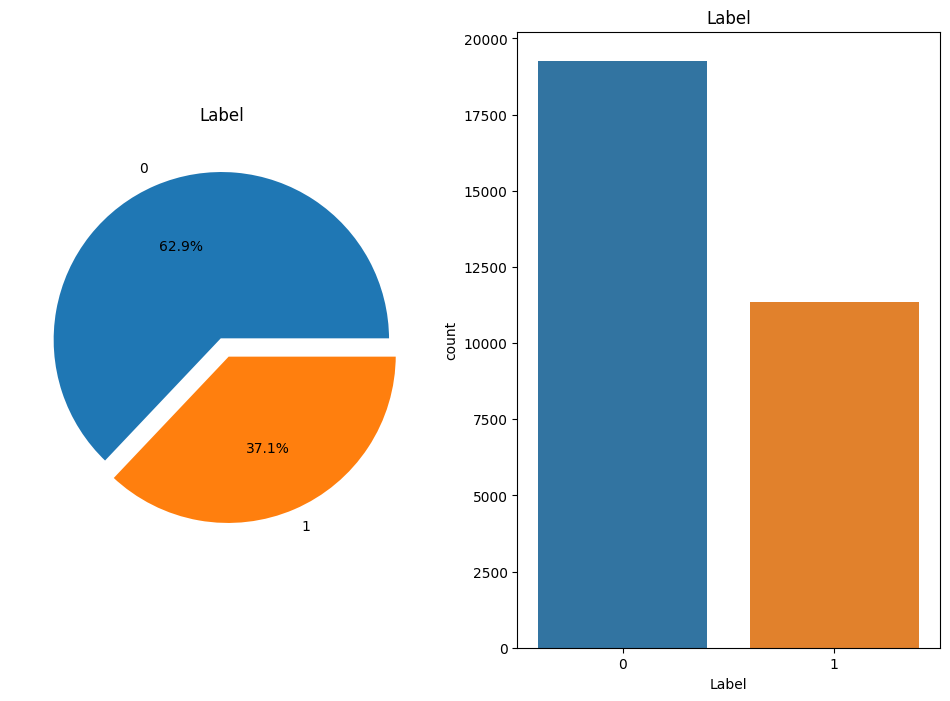

In [227]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
f, ax = plt.subplots(1, 2, figsize=(12, 8))
colors = list(mcolors.TABLEAU_COLORS.values())
train_data['Label'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], wedgeprops={'edgecolor': 'white', 'linewidth': 2, 'antialiased': True}, colors=colors)

ax[0].set_title('Label')
ax[0].set_ylabel('')
sns.countplot(x='Label', data=train_data, ax=ax[1], palette=colors)
ax[1].set_title('Label')
plt.show()

In [228]:

##def clean_text(text):
   ## return str(text).strip()

#train_data['Sentence'] = train_data['Sentence'].apply(clean_text)
#test_data['Sentence'] = test_data['Sentence'].apply(clean_text)

In [229]:
train_data

,Sentence,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1
...,...,...
30609,DELETE FROM door WHERE grow = 'small',0
30610,DELETE FROM tomorrow,0
30611,SELECT wide ( s ) FROM west,0
30612,SELECT * FROM ( SELECT slide FROM breath ),0


#### Tokenization (keeping all characters)


In [230]:

vocab_size = 15000
tokenizer = Tokenizer(
    num_words=vocab_size,
    oov_token="<OOV>",
    filters='',
    lower=False
)
tokenizer.fit_on_texts(train_data['Sentence'])


#### Adaptive Padding

In [231]:

max_len = int(np.percentile([len(x.split()) for x in train_data['Sentence']], 95))
X = tokenizer.texts_to_sequences(train_data['Sentence'])
X = pad_sequences(X, padding='post', maxlen=max_len)
y = train_data['Label'].astype('int')


#### Train/Validation Split


In [232]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


#### Model Architecture

In [233]:

embedding_dim = 256
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    LSTM(128),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


#### Model Compilation with Early Stopping and Adam Optimizer


In [234]:
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


#### Model Training

In [235]:

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9439 - loss: 0.1400 - val_accuracy: 0.9948 - val_loss: 0.0376
Epoch 2/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8677 - loss: 0.2540 - val_accuracy: 0.7783 - val_loss: 0.3926
Epoch 3/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7709 - loss: 0.3990 - val_accuracy: 0.7788 - val_loss: 0.3920
Epoch 4/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7737 - loss: 0.3977 - val_accuracy: 0.7788 - val_loss: 0.3921


#### Plotting Loss and Accuracy over Epochs


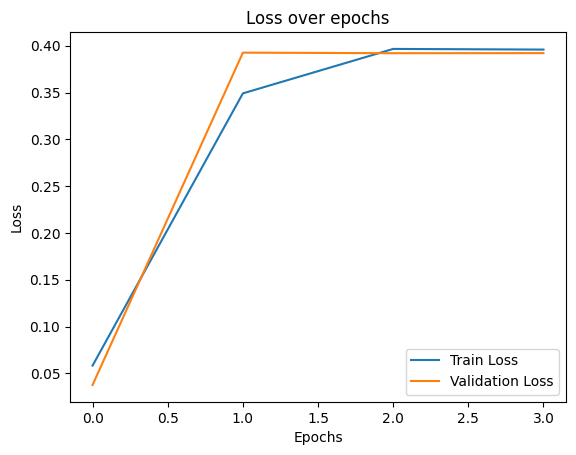

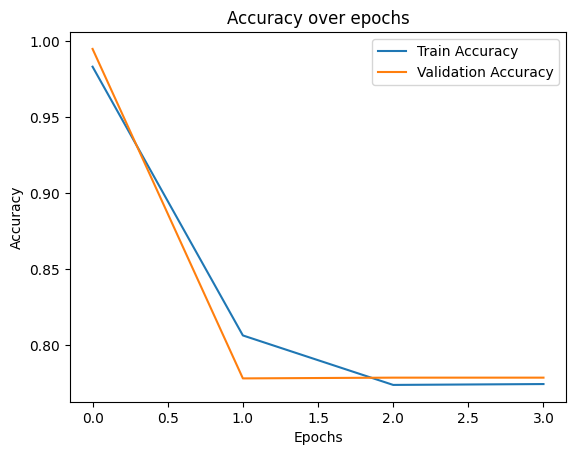

In [236]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Évaluation

In [237]:
test_data['Sentence'] = test_data['Sentence'].astype(str).fillna('')
X_test = tokenizer.texts_to_sequences(test_data['Sentence'])
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)
y_test = test_data['Label'].astype('int')
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'\n✅ Test Accuracy: {test_accuracy:.4f}')
print(f'❌ Test Loss: {test_loss:.4f}')

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9781 - loss: 0.1545

✅ Test Accuracy: 0.9942
❌ Test Loss: 0.0417


#### Filter Only SQL Injection (Label = 1)


In [238]:

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

sqli_only = test_data[test_data['Label'] == 1].copy()
print(f"\n📌 Nombre total des injections SQL dans test_data : {len(sqli_only)}")

# Nettoyage éventuel
##sqli_only['Sentence'] = sqli_only['Sentence'].apply(clean_text)





📌 Nombre total des injections SQL dans test_data : 11424


#### Preprocessing SQL Injection Sentences


In [239]:

X_sqli = tokenizer.texts_to_sequences(sqli_only['Sentence'])
X_sqli = pad_sequences(X_sqli, padding='post', maxlen=max_len)
y_sqli_true = np.ones(len(sqli_only))  # Tous sont censés être des injections

#### Prediction and Metrics Evaluation


In [240]:

sqli_preds = model.predict(X_sqli)
sqli_preds_labels = (sqli_preds > 0.5).astype(int)

357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [241]:

true_positives = np.sum(sqli_preds_labels == 1)
detection_rate = (true_positives / len(sqli_only)) * 100
accuracy = accuracy_score(y_sqli_true, sqli_preds_labels)
precision = precision_score(y_sqli_true, sqli_preds_labels)
recall = recall_score(y_sqli_true, sqli_preds_labels)
f1 = f1_score(y_sqli_true, sqli_preds_labels)

In [242]:

print(f"\n✅ Injections correctement détectées : {true_positives}")
print(f"📊 Taux de détection : {detection_rate:.2f}%")
print(f"\n🔍 Évaluation sur les requêtes SQL (Label = 1) :")
print(f"✅ Accuracy  : {accuracy * 100:.2f}%")
print(f"✅ Precision : {precision * 100:.2f}%")
print(f"✅ Recall    : {recall * 100:.2f}%")
print(f"✅ F1 Score  : {f1 * 100:.2f}%")



✅ Injections correctement détectées : 11231
📊 Taux de détection : 98.31%

🔍 Évaluation sur les requêtes SQL (Label = 1) :
✅ Accuracy  : 98.31%
✅ Precision : 100.00%
✅ Recall    : 98.31%
✅ F1 Score  : 99.15%


#### Filter Only Normal Queries (Label = 0)


In [243]:

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

normal_only = test_data[test_data['Label'] == 0].copy()
print(f"\n📌 Nombre total des requêtes normales dans test_data : {len(normal_only)}")


#normal_only['Sentence'] = normal_only['Sentence'].apply(clean_text)

  # Tous sont censés être des requêtes normales






📌 Nombre total des requêtes normales dans test_data : 22302


#### Preprocessing Normal Queries Sentences


In [244]:

X_normal = tokenizer.texts_to_sequences(normal_only['Sentence'])
X_normal = pad_sequences(X_normal, padding='post', maxlen=max_len)
y_normal_true = np.zeros(len(normal_only))

#### Prediction and Metrics Evaluation


In [220]:

normal_preds = model.predict(X_normal)
normal_preds_labels = (normal_preds > 0.5).astype(int)

697/697 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [221]:

print("\n📊 Évaluation sur les requêtes normales (Label = 0):")
print(f"✅ Accuracy : {accuracy_score(y_normal_true, normal_preds_labels) * 100:.2f}%")
print(f"✅ Precision : {precision_score(y_normal_true, normal_preds_labels, pos_label=0, zero_division=0) * 100:.2f}%")
print(f"✅ Recall : {recall_score(y_normal_true, normal_preds_labels, pos_label=0, zero_division=0) * 100:.2f}%")
print(f"✅ F1 Score : {f1_score(y_normal_true, normal_preds_labels, pos_label=0, zero_division=0) * 100:.2f}%")



📊 Évaluation sur les requêtes normales (Label = 0):
✅ Accuracy : 99.83%
✅ Precision : 100.00%
✅ Recall : 99.83%
✅ F1 Score : 99.91%
